In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
COLOR_TREAT = "#2ecc71"
COLOR_NO_TREAT = "#e74c3c"
%config InlineBackend.figure_format = 'retina'

In [108]:
lalonde = pd.read_csv('lalonde.csv')
#lalonde.set_index('id', drop=True, inplace=True)
lalonde.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


## 1. Naive analysis

TODO make a plot more comparable

In [109]:
def plot_distrib(s1, s2, title, xLabel, yLabel, ax=None):
    bins = np.histogram(s1)[1]
    sns.distplot(s1, kde=False, color=COLOR_NO_TREAT, norm_hist=True, ax=ax, bins=bins)
    sns.distplot(s2, kde=False, color=COLOR_TREAT, norm_hist=True, ax=ax, bins=bins)
    if ax is None:
        plt.title(title)
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)
        plt.legend(['No treatment', 'Treatment'])
    else:
        ax.set_title(title)
        ax.set_xlabel(xLabel)
        ax.set_ylabel(yLabel)
        ax.legend(['No treatment', 'Treatment'])

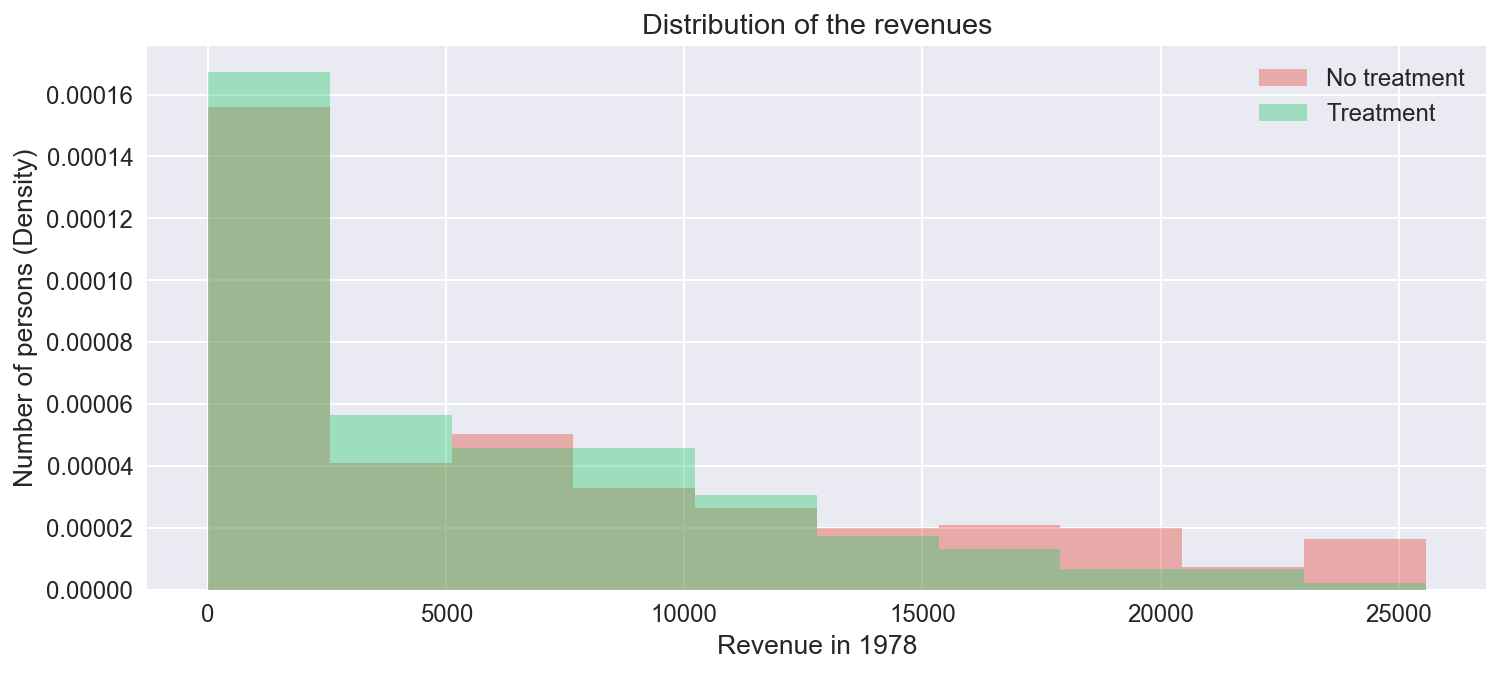

In [110]:
plt.figure(figsize=(12,5))
plot_distrib(s1=lalonde.re78[lalonde['treat'] == 0], s2=lalonde.re78[lalonde['treat'] == 1], title='Distribution of the revenues', ax=None, xLabel='Revenue in 1978', yLabel='Number of persons (Density)')

Let's compare the average earnings of people that have/have not participated the job training:

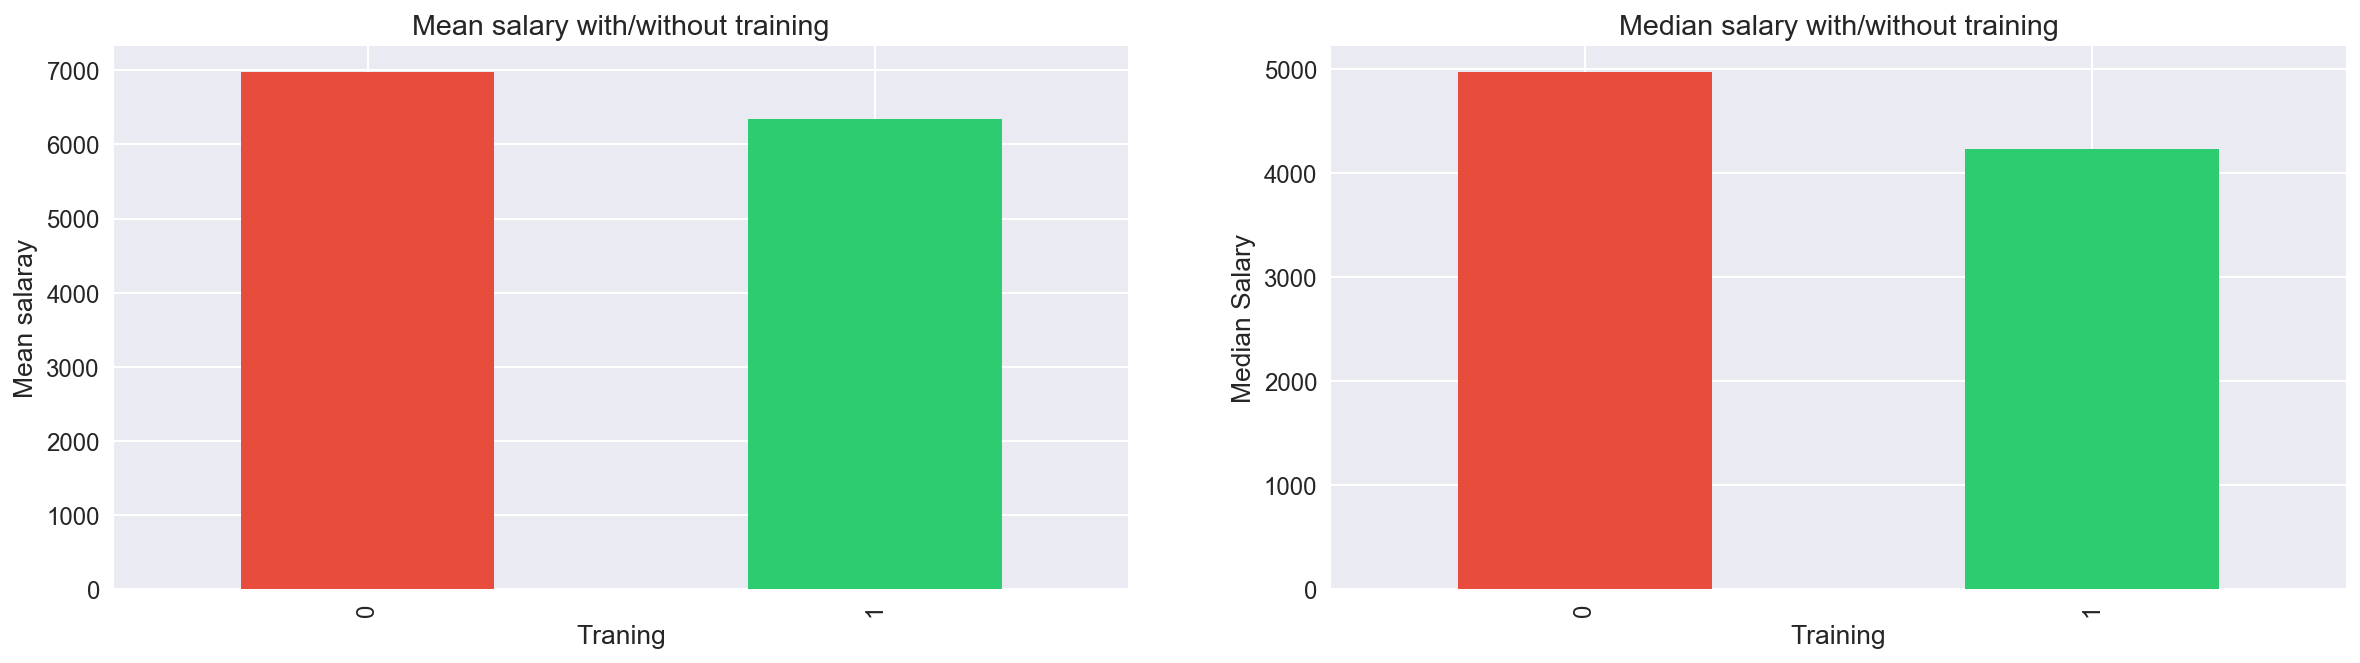

In [111]:
plt.figure(figsize=(20,5))
axes = plt.subplot(121)
lalonde.groupby(['treat'])['re78'].mean().plot.bar(color=[COLOR_NO_TREAT, COLOR_TREAT])
plt.title('Mean salary with/without training')
plt.ylabel('Mean salaray')
plt.xlabel('Traning')
plt.subplot(122)
lalonde.groupby(['treat'])['re78'].median().plot.bar(color=[COLOR_NO_TREAT, COLOR_TREAT])
plt.title('Median salary with/without training')
plt.ylabel('Median Salary')
plt.xlabel('Training')

## 2. A closer look at the data

In [112]:
# distinguish categorical from non-categorical features
sns.set(font_scale=1.2)
lalonde_cat = lalonde[['black', 'hispan', 'married', 'nodegree', 'treat']]
lalonde_non_cat = lalonde[['age', 'educ', 're74', 're75', 're78', 'treat']]

### For each feature, compare its distribution in the treated group with its distribution in the control group

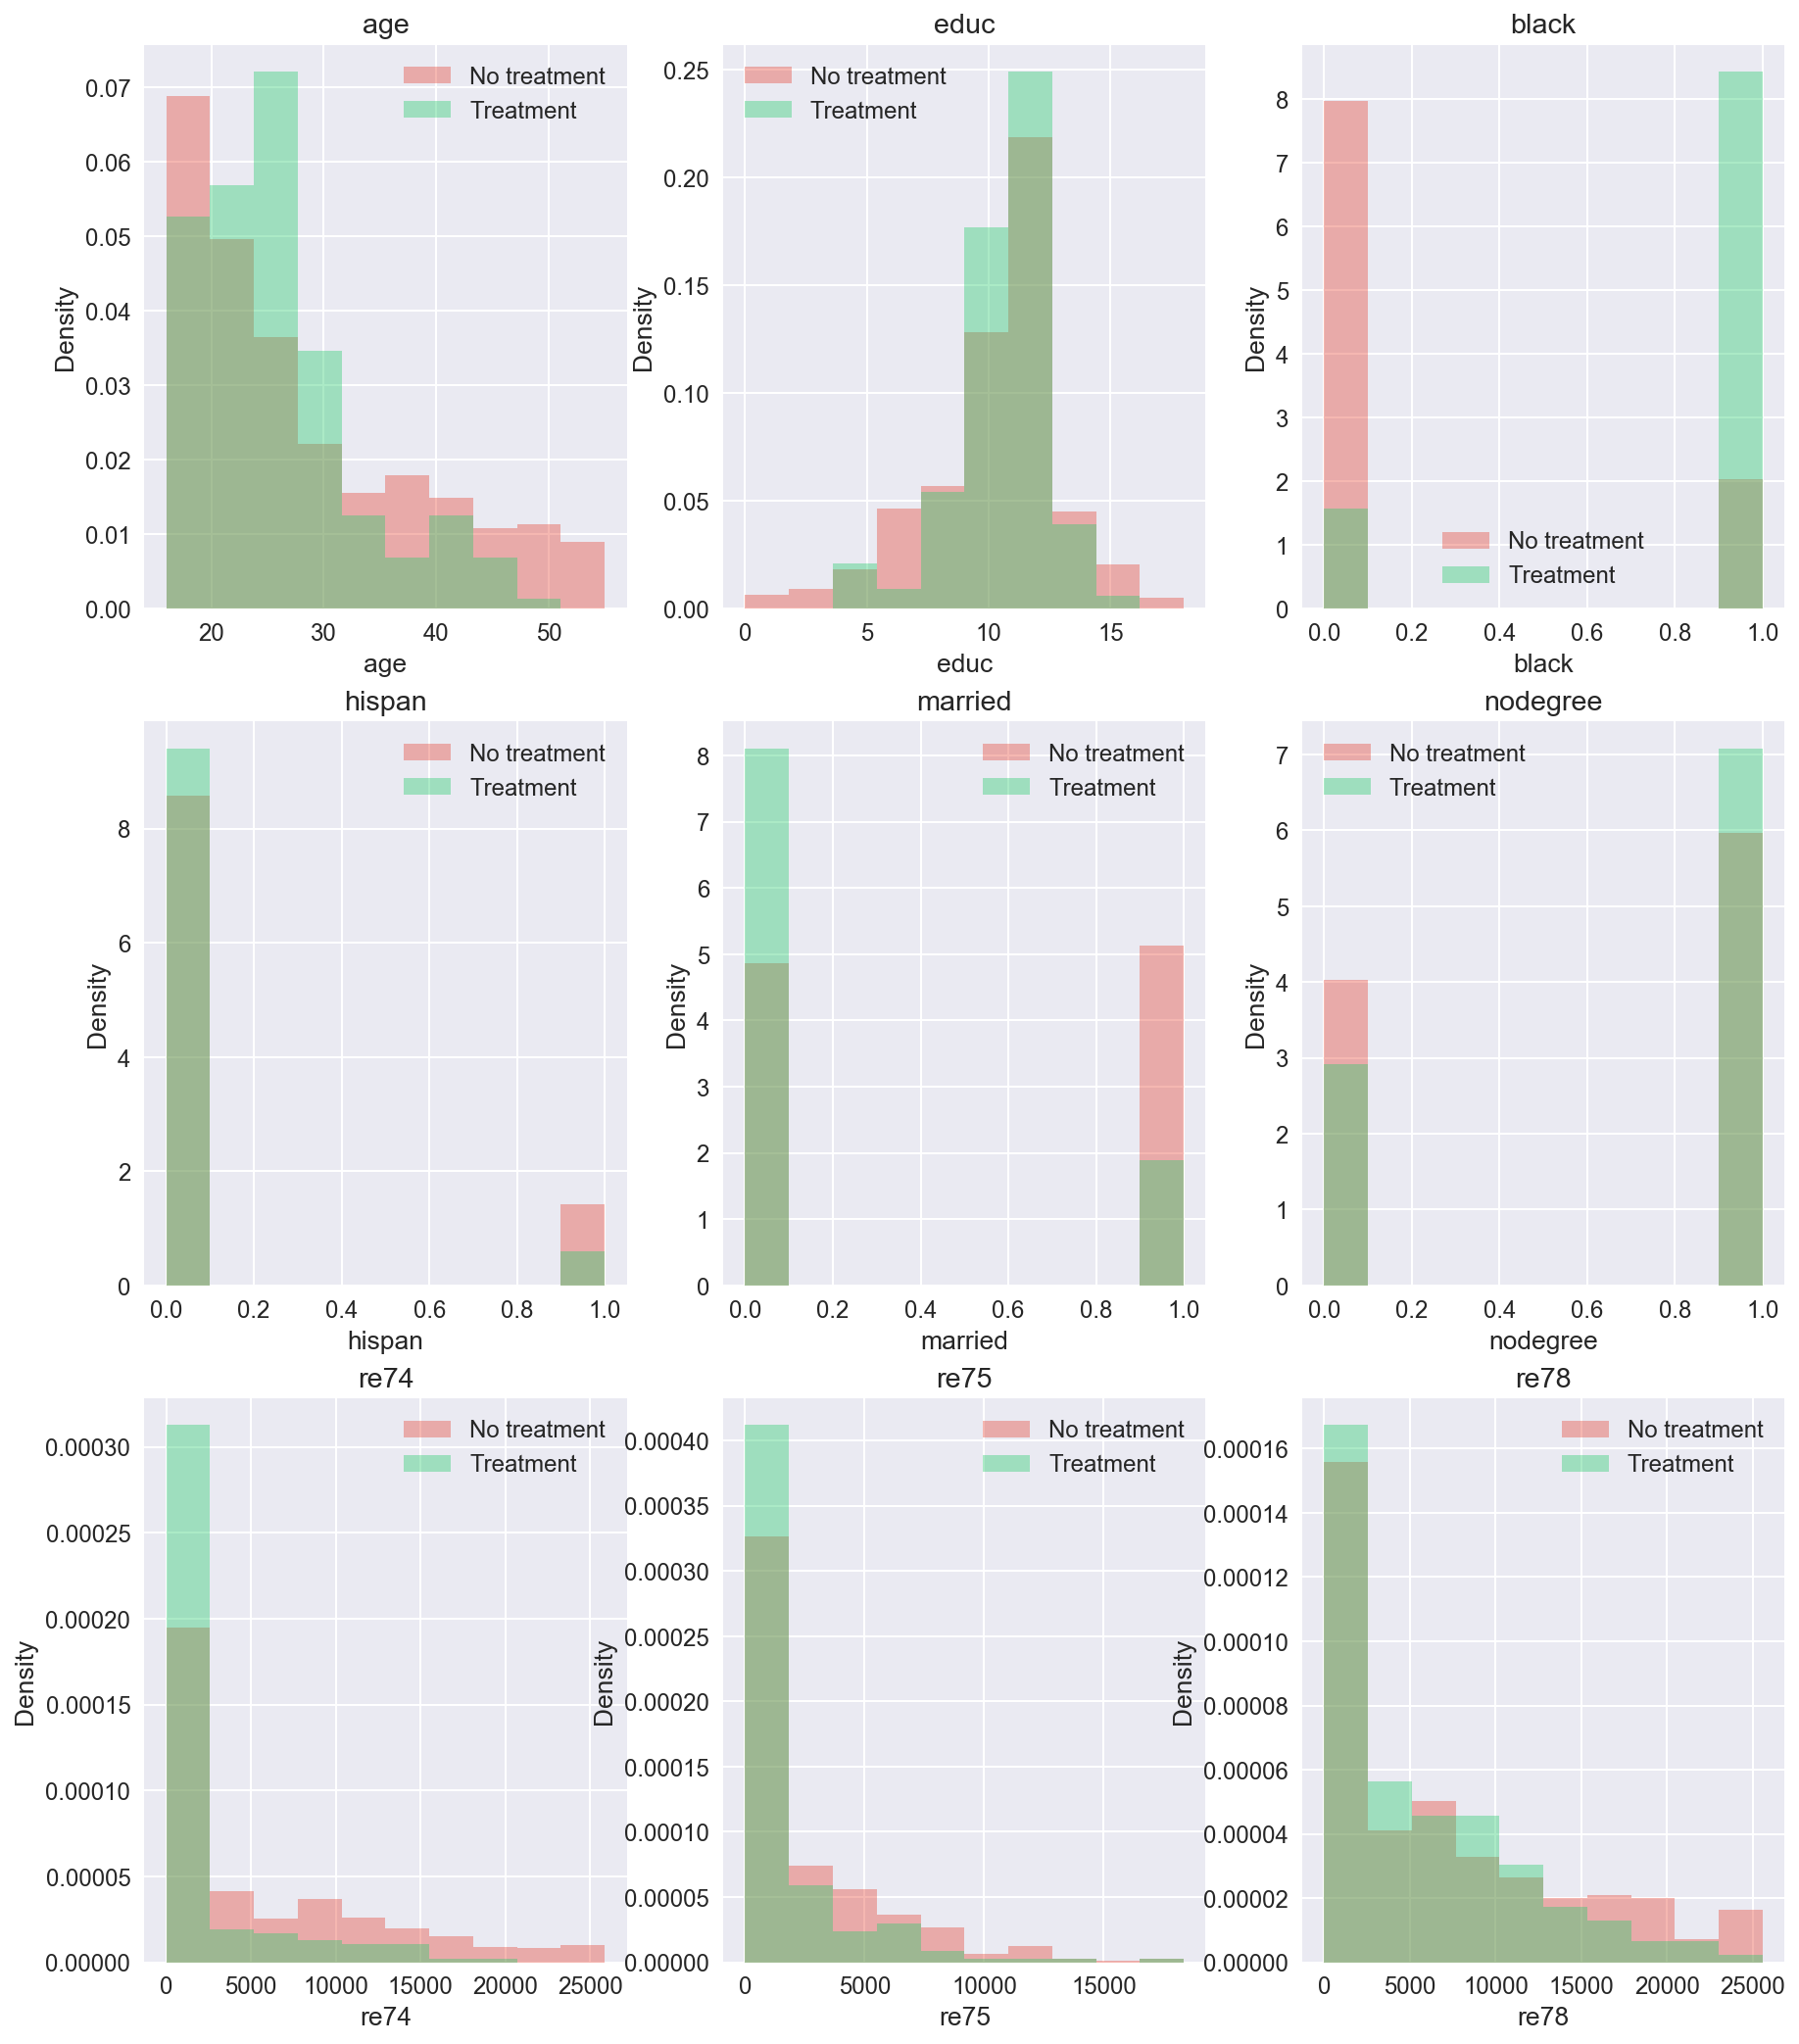

In [113]:
f, axarr = plt.subplots(3, 3, figsize=(15, 18))
for index, feature in enumerate(['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']):
    ax = axarr[int(index/3)][index%3]
    plot_distrib(s1=lalonde[feature][lalonde['treat'] == 0], s2=lalonde[feature][lalonde['treat'] == 1], title=feature, xLabel = feature, yLabel='Density', ax=ax)

### Pairwise analysis of features' distribution
Comparing the distrbution of features for each distinct feature tuple can give additional information:
**TODO : décrire les obs**

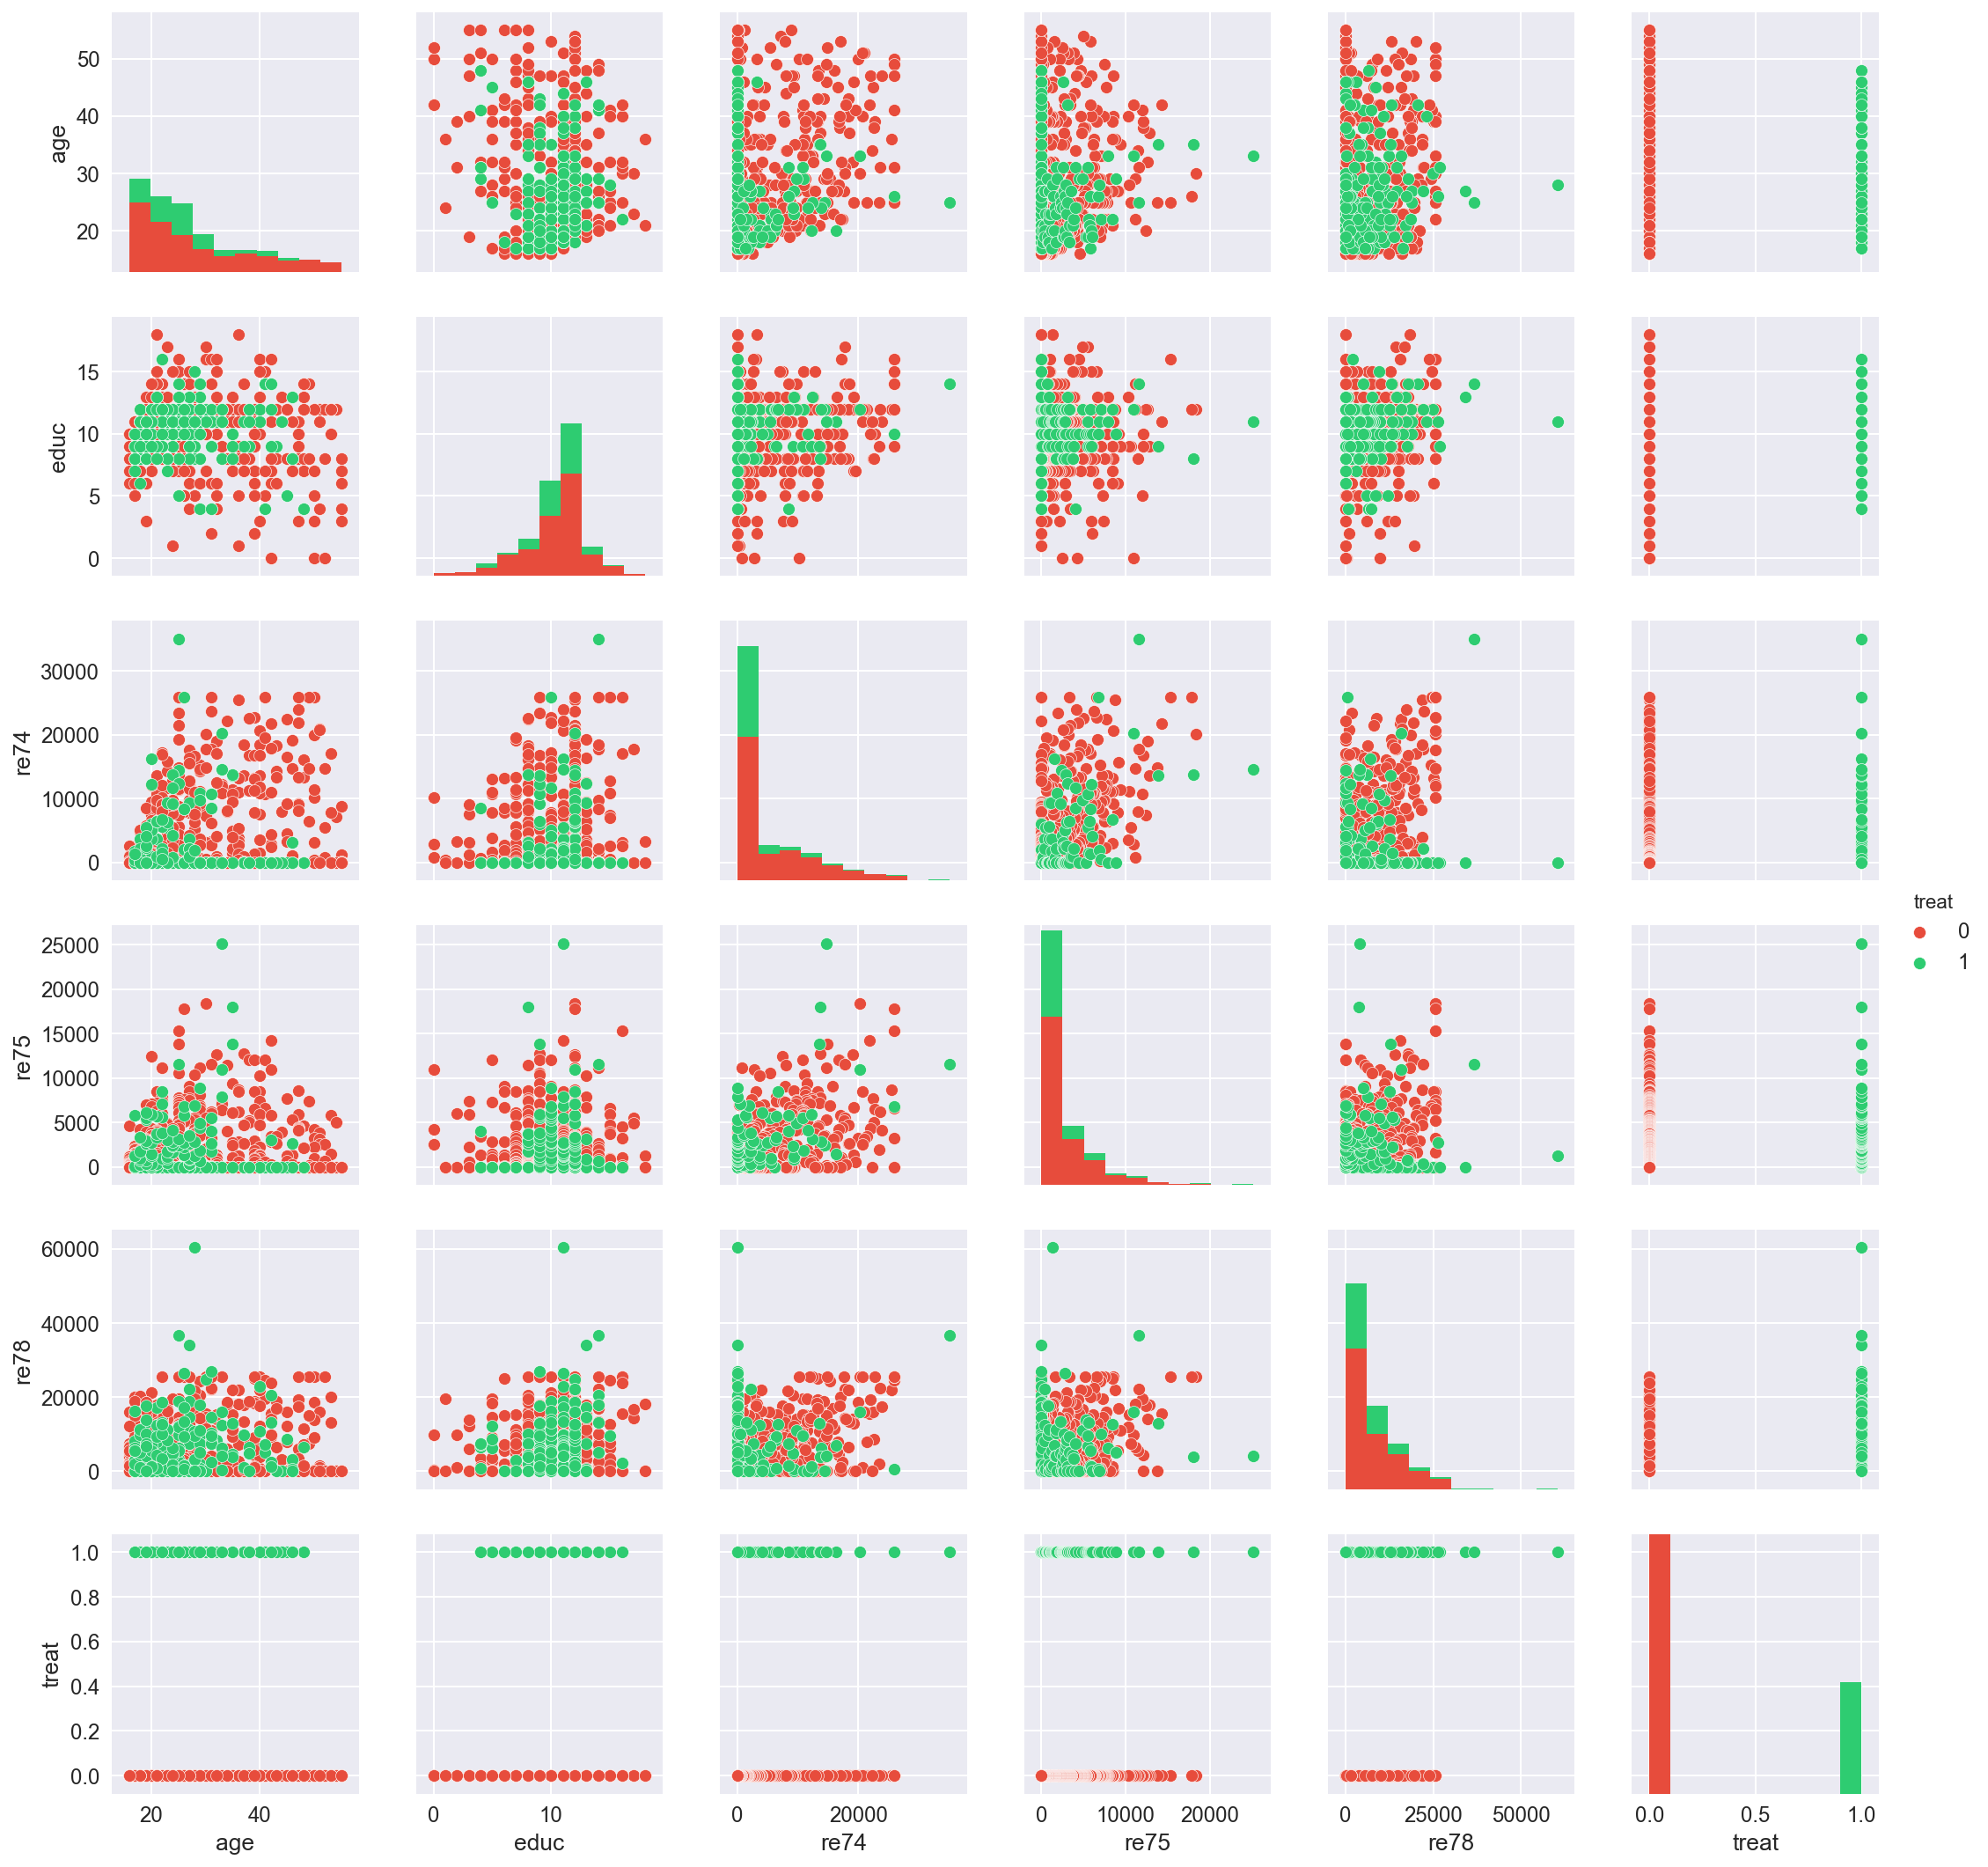

In [114]:
sns.pairplot(lalonde_non_cat, hue='treat', palette={0:"#e74c3c", 1: "#2ecc71"})

## 3. A propsensity score model
We should fit our model on the pre treatment features, though we will have to remove the re78 feature.

In [115]:
import sklearn.linear_model

lal = lalonde.drop(['id','treat','re78'],1)
lal = preprocessing.scale(lal)
model = sklearn.linear_model.LogisticRegression()
model.fit(lal, lalonde.treat)
pred = model.predict_proba(lal)

In [116]:
sum(model.predict(lal) == lalonde.treat)/len(lal)

0.8241042345276873

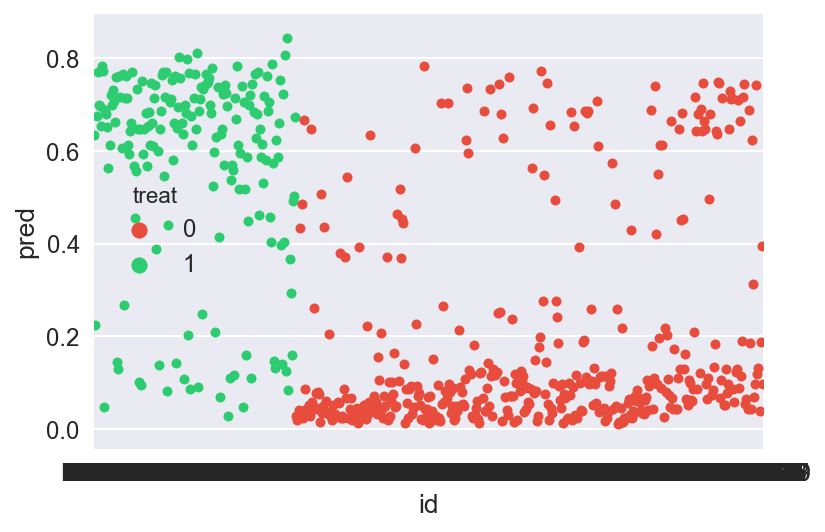

In [117]:
lalonde['pred'] = pred[:,1]
ax = sns.stripplot(x='id', y='pred', hue='treat', data=lalonde, palette={0:"#e74c3c", 1: "#2ecc71"})

## 4. Balancing the dataset via matching
Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group. (Hint: you may explore the networkx package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores. In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects. Compare the outcomes (re78) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects. What do you observe? Are you closer to being able to draw valid conclusions now than you were before?

In [118]:
import networkx as nx
from networkx.algorithms import bipartite
#graph_size = lalonde['treat'].value_counts()
#G = nx.complete_bipartite_graph(graph_size[0], graph_size[1])
#G.add_nodes_from(lalonde['id'][lalonde.treat == 0], bipartite=0) # Add the node attribute "bipartite"
#G.add_nodes_from(lalonde['id'][lalonde.treat == 1], bipartite=1)

G=nx.Graph()
G.add_nodes_from(lalonde['id'][lalonde.treat == 0]) # Add the node attribute "bipartite"
G.add_nodes_from(lalonde['id'][lalonde.treat == 1])


In [119]:
for ID_u, score_u in zip(lalonde.id[lalonde.treat == 0], lalonde.pred[lalonde.treat == 0]):
    for ID_v, score_v in zip(lalonde.id[lalonde.treat == 1], lalonde.pred[lalonde.treat == 1]):
        G.add_edge(ID_u, ID_v, weight=-abs(score_u-score_v))

In [120]:
#G.number_of_nodes()
G.number_of_edges()
#nx.draw(G)

79365

In [122]:
from networkx.algorithms import max_weight_matching
matching = max_weight_matching(G, maxcardinality=True)

In [123]:
res = dict()
for key in matching.keys():
    if(key[0] == 'N'):
        res[key] = matching[key]
res

{'NSW1': 'PSID41',
 'NSW10': 'PSID109',
 'NSW100': 'PSID240',
 'NSW101': 'PSID395',
 'NSW102': 'PSID417',
 'NSW103': 'PSID170',
 'NSW104': 'PSID31',
 'NSW105': 'PSID388',
 'NSW106': 'PSID423',
 'NSW107': 'PSID410',
 'NSW108': 'PSID69',
 'NSW109': 'PSID180',
 'NSW11': 'PSID86',
 'NSW110': 'PSID358',
 'NSW111': 'PSID159',
 'NSW112': 'PSID79',
 'NSW113': 'PSID84',
 'NSW114': 'PSID179',
 'NSW115': 'PSID428',
 'NSW116': 'PSID122',
 'NSW117': 'PSID387',
 'NSW118': 'PSID357',
 'NSW119': 'PSID161',
 'NSW12': 'PSID370',
 'NSW120': 'PSID6',
 'NSW121': 'PSID265',
 'NSW122': 'PSID111',
 'NSW123': 'PSID218',
 'NSW124': 'PSID38',
 'NSW125': 'PSID379',
 'NSW126': 'PSID380',
 'NSW127': 'PSID66',
 'NSW128': 'PSID183',
 'NSW129': 'PSID258',
 'NSW13': 'PSID217',
 'NSW130': 'PSID224',
 'NSW131': 'PSID8',
 'NSW132': 'PSID425',
 'NSW133': 'PSID278',
 'NSW134': 'PSID308',
 'NSW135': 'PSID188',
 'NSW136': 'PSID330',
 'NSW137': 'PSID344',
 'NSW138': 'PSID427',
 'NSW139': 'PSID24',
 'NSW14': 'PSID5',
 'NSW140':

In [124]:
lalonde_treated = lalonde[lalonde['treat'] == 1]
lalonde_treated['temp'] = 1
#lalonde_treated

lalonde_nt = lalonde[lalonde['treat'] == 0]
lalonde_nt['temp'] = 1
#lalonde_nt

result = pd.merge(lalonde_treated, lalonde_nt, on='temp')
result = result[['id_x' , 'id_y' , 'pred_x' , 'pred_y']]
result['diff'] = abs(result['pred_x'] - result['pred_y'])
result = result.set_index(['id_x', 'id_y'])
sum(result.loc[list(res.items())]['diff'])


/Users/LouisDuv/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/LouisDuv/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


39.15286960538313

In [125]:
result.loc[list(res.items())]

,,pred_x,pred_y,diff
id_x,id_y,,,
NSW86,PSID184,0.797873,0.120680,0.677194
NSW70,PSID140,0.705302,0.702735,0.002567
NSW25,PSID160,0.717027,0.128095,0.588932
NSW182,PSID207,0.159108,0.125489,0.033618
NSW110,PSID358,0.524885,0.161557,0.363328
NSW118,PSID357,0.647600,0.128340,0.519261
NSW153,PSID342,0.647075,0.107928,0.539147
NSW168,PSID157,0.624500,0.622846,0.001653
NSW16,PSID182,0.719981,0.129486,0.590494


In [126]:
lalonde.set_index('id' , inplace = True)
matched = lalonde.loc[list(matching.keys())]


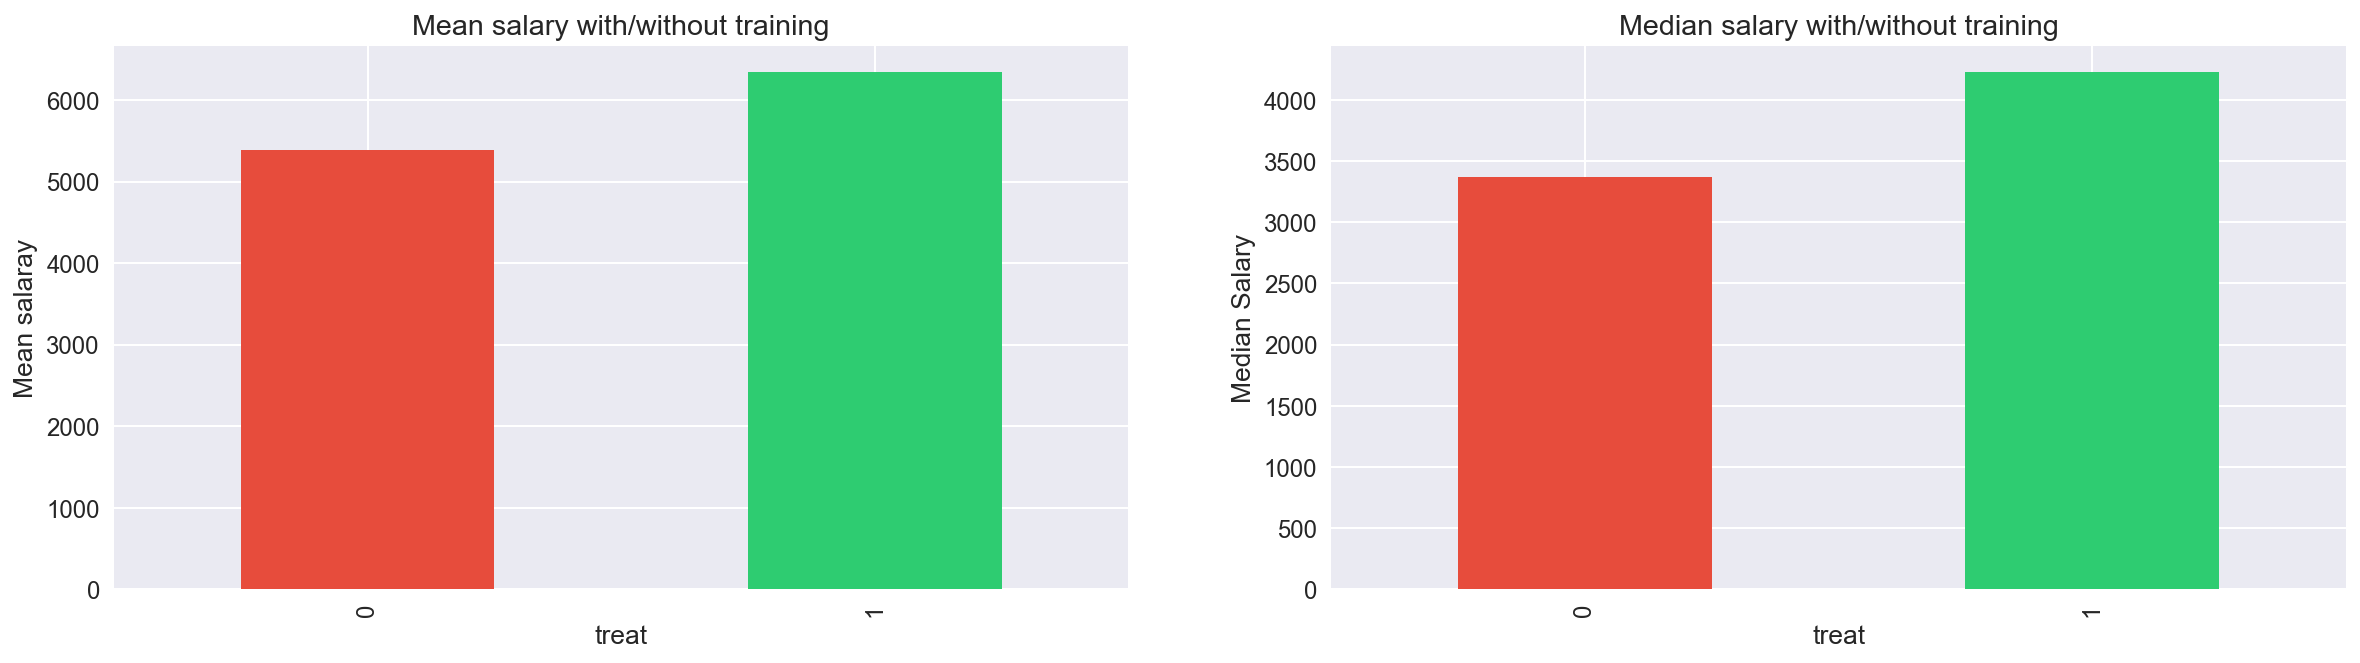

In [127]:
matched = lalonde.loc[list(matching.keys())]
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Mean salary with/without training')
plt.ylabel('Mean salaray')
matched.groupby(['treat'])['re78'].mean().plot.bar(color=[COLOR_NO_TREAT, COLOR_TREAT])
plt.subplot(122)
plt.title('Median salary with/without training')
plt.ylabel('Median Salary')
matched.groupby(['treat'])['re78'].median().plot.bar(color=[COLOR_NO_TREAT, COLOR_TREAT])

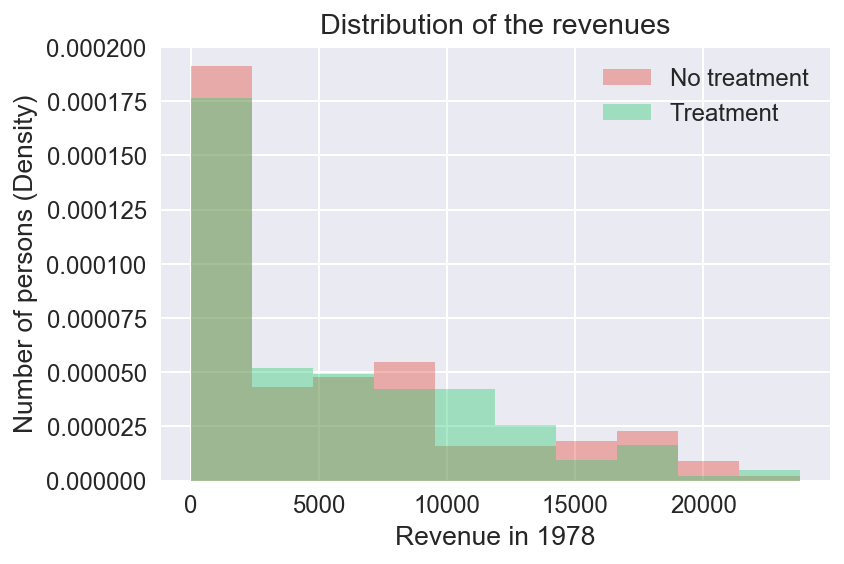

In [128]:
plot_distrib(s1=matched.re78[matched['treat'] == 0], s2=matched.re78[matched['treat'] == 1], 
             title='Distribution of the revenues', ax=None, xLabel='Revenue in 1978', yLabel='Number of persons (Density)')

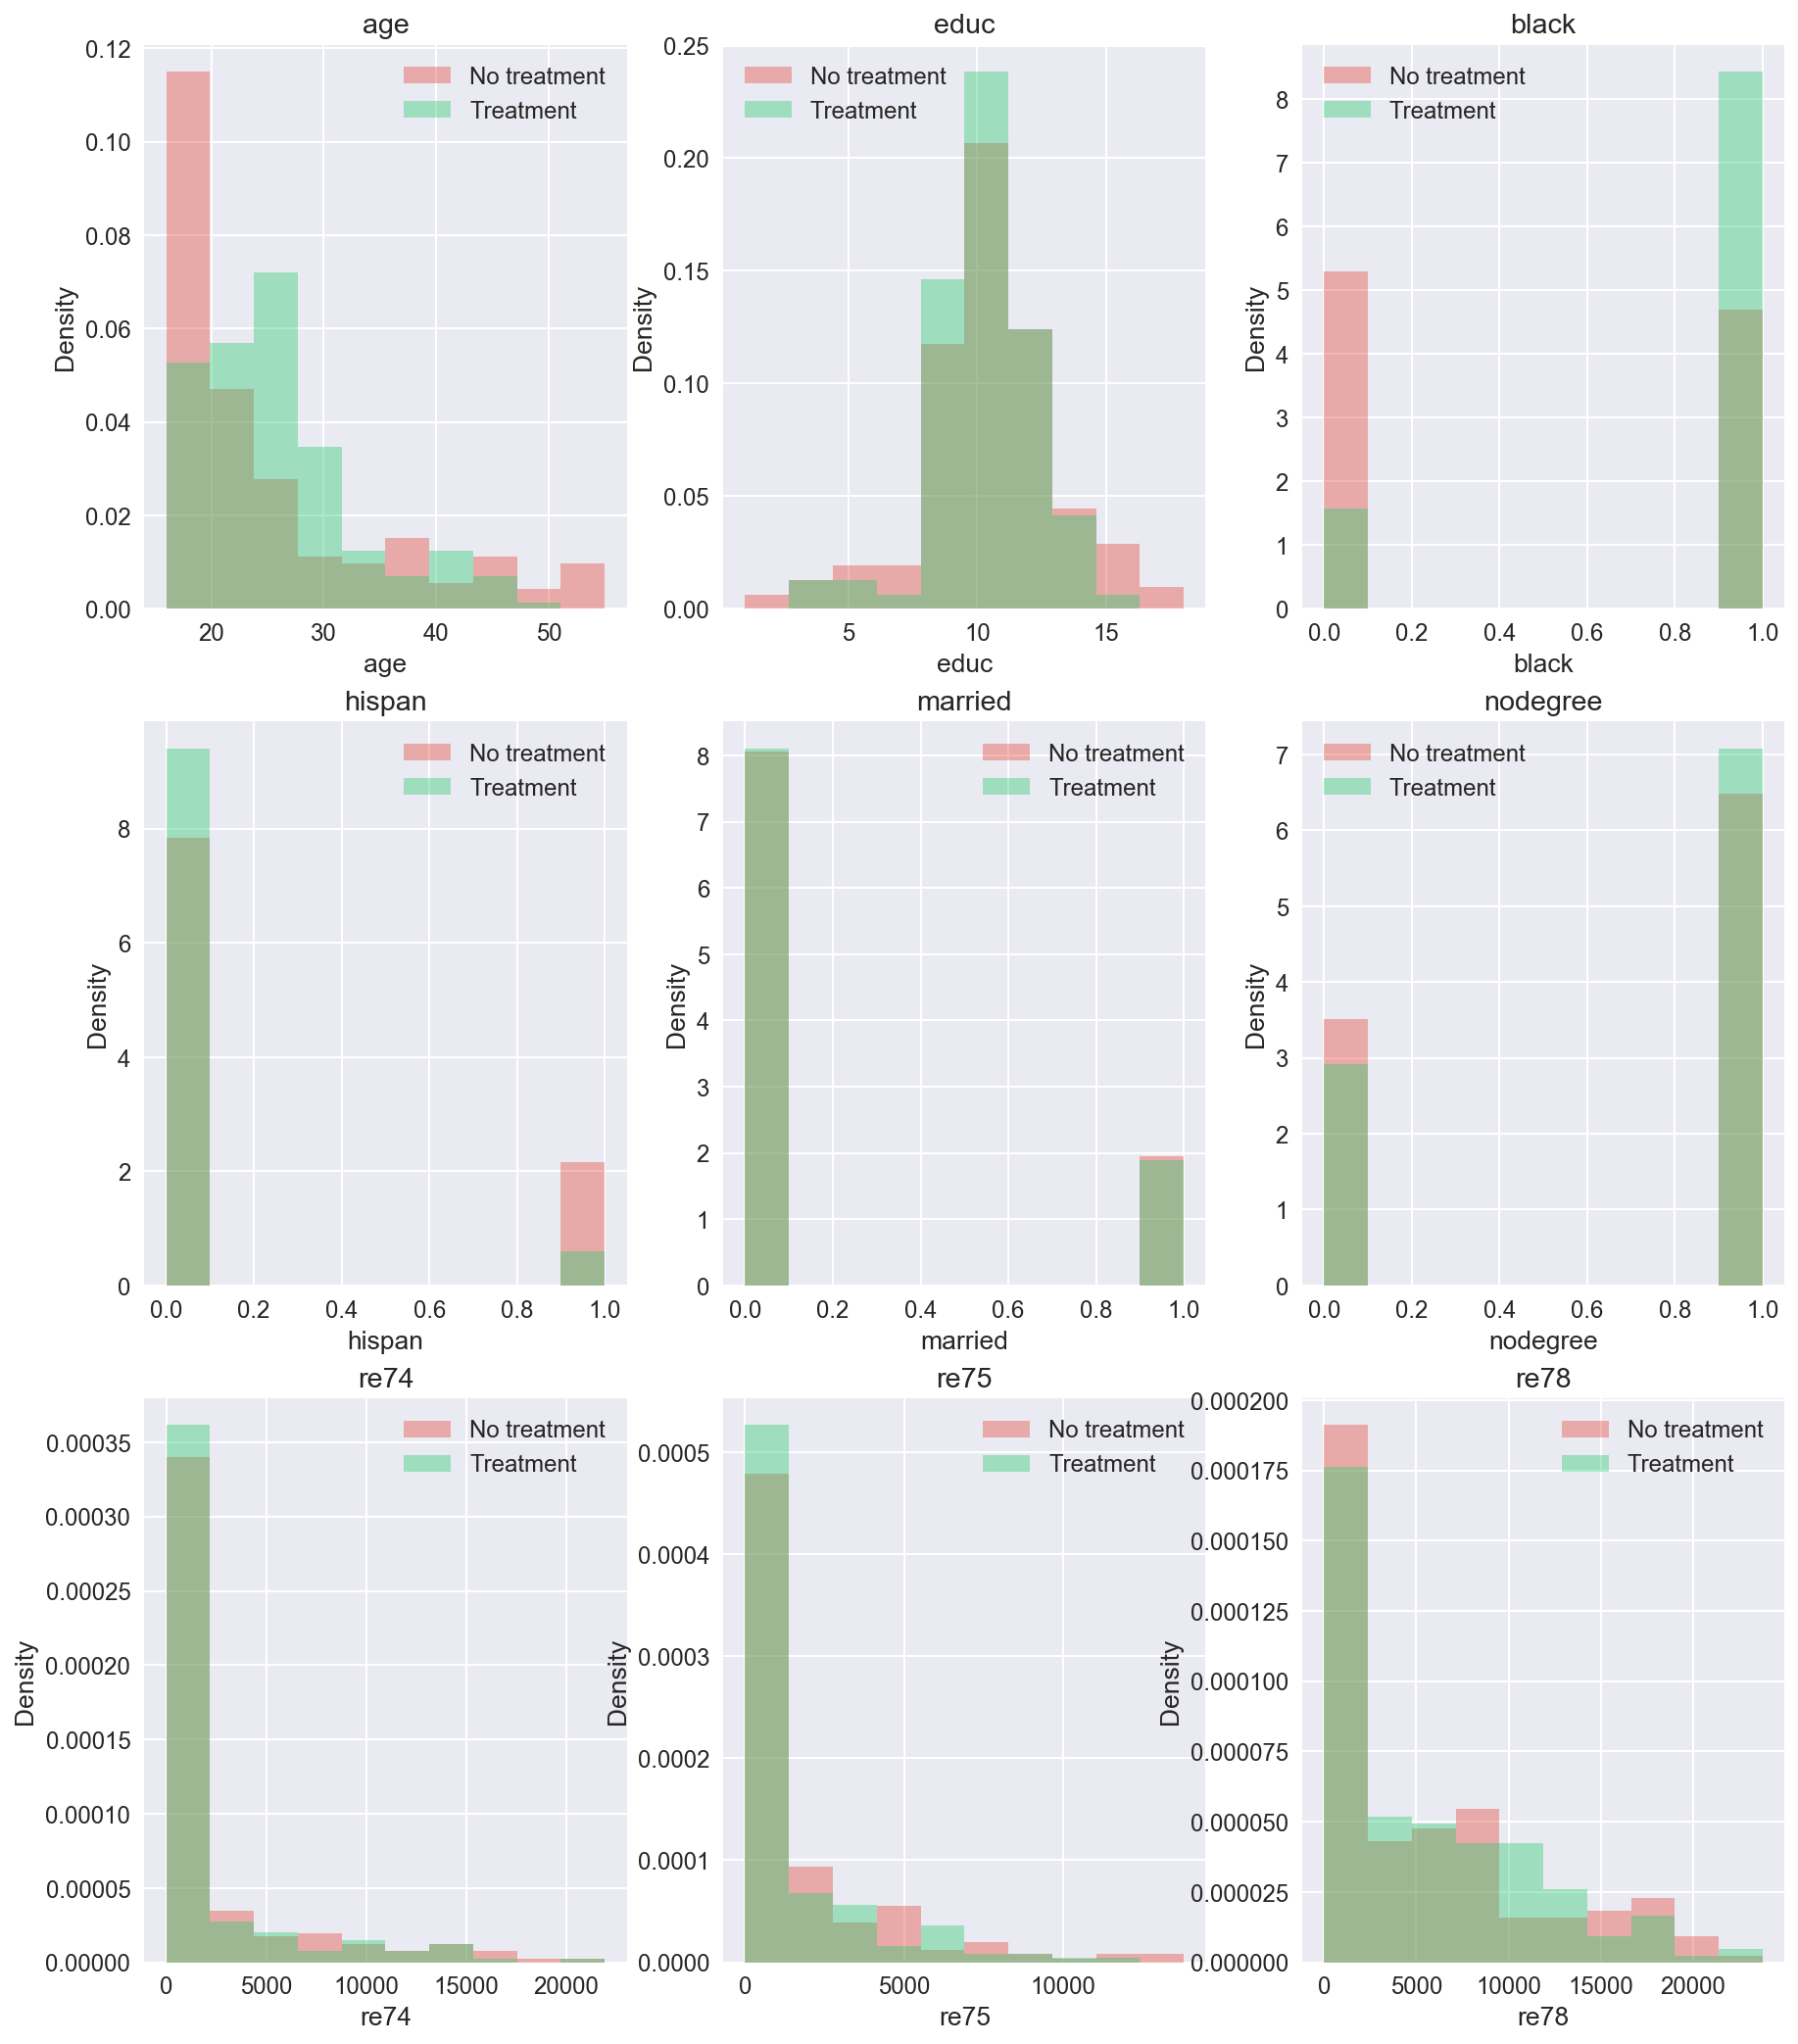

In [129]:
f, axarr = plt.subplots(3, 3, figsize=(15, 18))
for index, feature in enumerate(['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']):
    ax = axarr[int(index/3)][index%3]
    plot_distrib(s1=matched[feature][matched['treat'] == 0], s2=matched[feature][matched['treat'] == 1], title=feature, xLabel = feature, yLabel='Density', ax=ax)

In [135]:
from scipy import stats
for feature in ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']:
    ks = stats.ks_2samp(matched[feature][matched['treat'] == 0], matched[feature][matched['treat'] == 1])
    print('For ' + str(feature)+ ' the KS stat and P-values are ' +str(ks))

For age the KS stat and P-values are Ks_2sampResult(statistic=0.27027027027027029, pvalue=1.8650050329873941e-06)
For educ the KS stat and P-values are Ks_2sampResult(statistic=0.064864864864864868, pvalue=0.81873911619854023)
For black the KS stat and P-values are Ks_2sampResult(statistic=0.37297297297297299, pvalue=6.5589070973707025e-12)
For hispan the KS stat and P-values are Ks_2sampResult(statistic=0.15675675675675682, pvalue=0.018724917091719574)
For married the KS stat and P-values are Ks_2sampResult(statistic=0.0054054054054054612, pvalue=0.99999999999999989)
For nodegree the KS stat and P-values are Ks_2sampResult(statistic=0.059459459459459463, pvalue=0.88999360513867343)
For re74 the KS stat and P-values are Ks_2sampResult(statistic=0.29189189189189185, pvalue=1.8502472620824238e-07)
For re75 the KS stat and P-values are Ks_2sampResult(statistic=0.21621621621621617, pvalue=0.00027644325862747623)
For re78 the KS stat and P-values are Ks_2sampResult(statistic=0.0810810810810

## 5. Balancing the groups further
The "balanced" mode uses the values of y to automatically adjust
    weights inversely proportional to class frequencies in the input data
    as ``n_samples / (n_classes * np.bincount(y))`

In [138]:
lalonde = pd.read_csv('lalonde.csv')
lal = lalonde.drop(['id','treat','re78'],1)
lal = preprocessing.scale(lal)
model = sklearn.linear_model.LogisticRegression()
model.fit(lal, lalonde.treat)
pred = model.predict_proba(lal)
lalonde['pred'] = pred[:,1]


Gprime=nx.Graph()
Gprime.add_nodes_from(lalonde['id'][lalonde.treat == 0])
Gprime.add_nodes_from(lalonde['id'][lalonde.treat == 1])

lalonde_not_black = lalonde[lalonde.black == 0]
for ID_u, score_u in zip(lalonde_not_black.id[lalonde_not_black.treat == 0], lalonde_not_black.pred[lalonde_not_black.treat == 0]):
    for ID_v, score_v in zip(lalonde_not_black.id[lalonde_not_black.treat == 1], lalonde_not_black.pred[lalonde_not_black.treat == 1]):
        Gprime.add_edge(ID_u, ID_v, weight=-abs(score_u-score_v))

lalonde_black = lalonde[lalonde.black == 1]
for ID_u, score_u in zip(lalonde_black.id[lalonde_black.treat == 0], lalonde_black.pred[lalonde_black.treat == 0]):
    for ID_v, score_v in zip(lalonde_black.id[lalonde_black.treat == 1], lalonde_black.pred[lalonde_black.treat == 1]):
        Gprime.add_edge(ID_u, ID_v, weight=-abs(score_u-score_v))

In [139]:
matching = max_weight_matching(Gprime, maxcardinality=True)

In [142]:
matched

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,pred
id,,,,,,,,,,,
NSW25,1,18,10,1,0,0,1,0.00000,0.00000,11163.17000,0.717027
NSW70,1,29,13,1,0,0,0,0.00000,0.00000,7479.65600,0.705302
NSW128,1,23,10,1,0,1,1,0.00000,936.43860,11233.26000,0.559668
NSW182,1,25,14,1,0,1,0,35040.07000,11536.57000,36646.95000,0.159108
PSID216,0,32,6,0,1,1,1,979.63340,1036.59700,0.00000,0.085543
PSID326,0,45,8,1,0,0,1,3299.40500,0.00000,31.03226,0.689298
PSID256,0,17,8,1,0,0,1,0.00000,451.16130,0.00000,0.653574
PSID15,0,22,14,1,0,1,0,748.43990,11105.37000,18208.55000,0.646997
PSID255,0,23,11,0,1,1,1,8946.01200,469.06450,4776.01200,0.089891


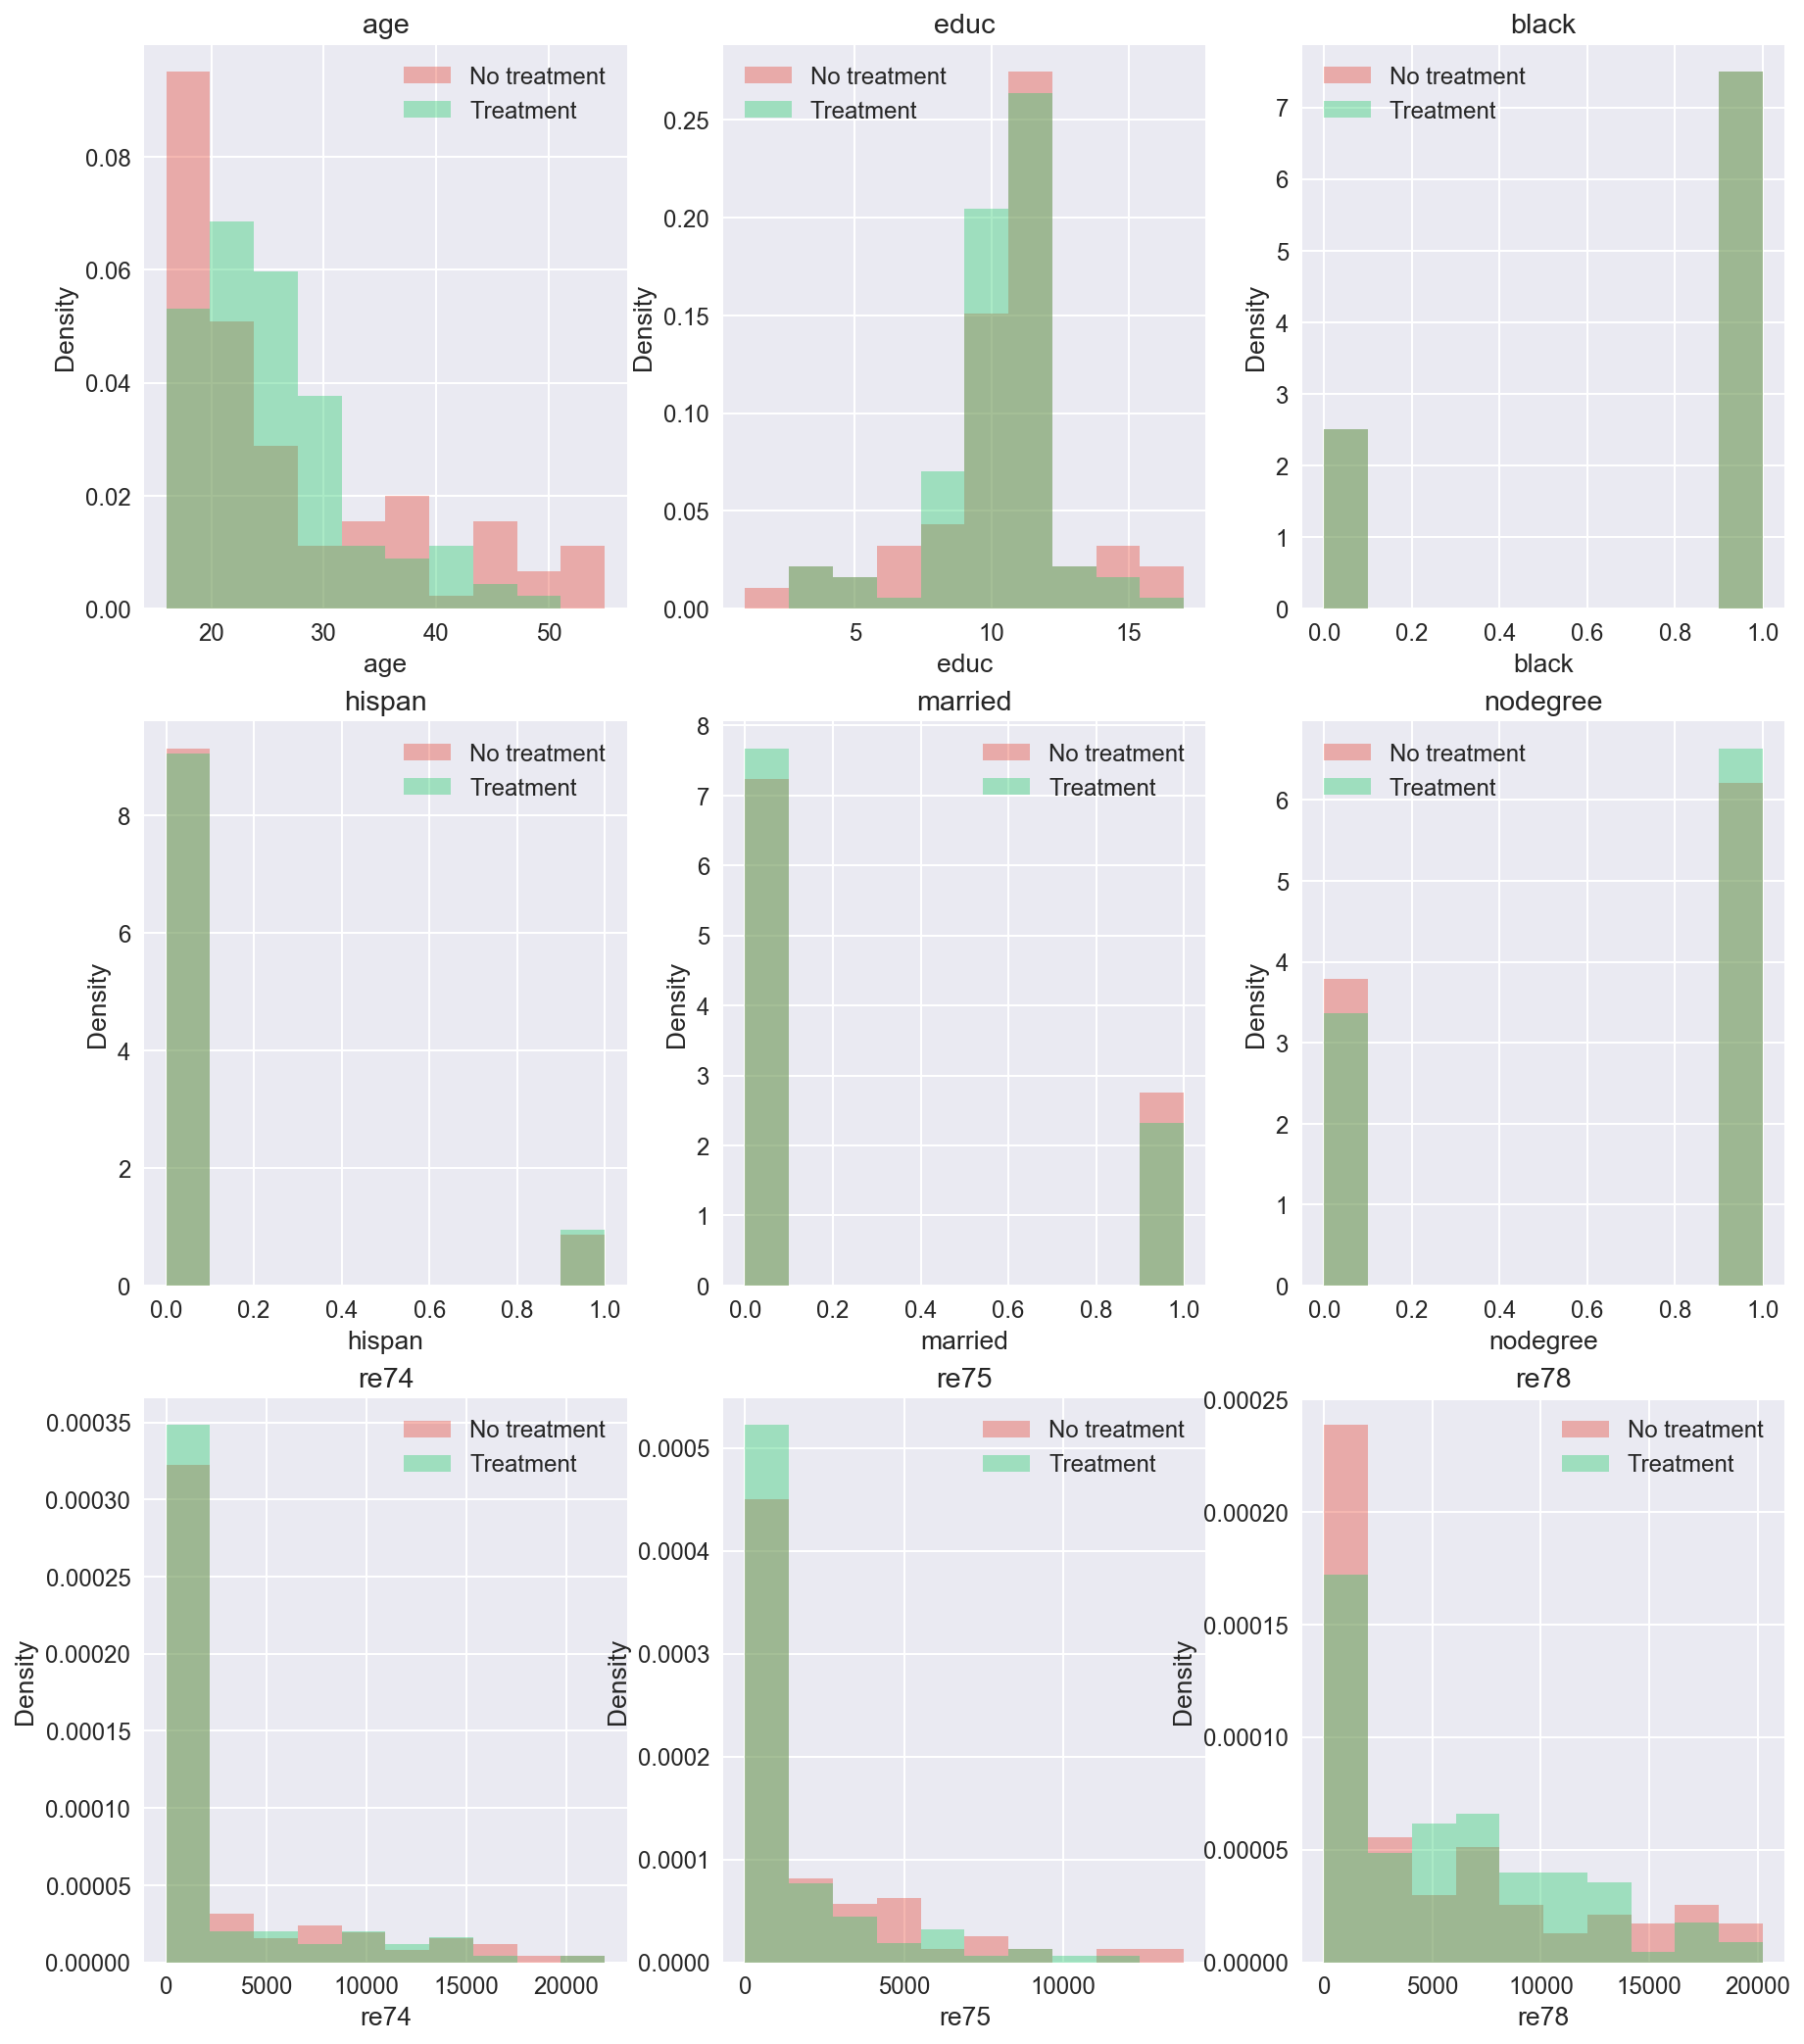

In [140]:
lalonde.set_index('id' , inplace = True)
matched = lalonde.loc[list(matching.keys())]

f, axarr = plt.subplots(3, 3, figsize=(15, 18))
for index, feature in enumerate(['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']):
    ax = axarr[int(index/3)][index%3]
    plot_distrib(s1=matched[feature][matched['treat'] == 0], s2=matched[feature][matched['treat'] == 1], title=feature, xLabel = feature, yLabel='Density', ax=ax)

In [141]:
from scipy import stats
for feature in ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']:
    ks = stats.ks_2samp(matched[feature][matched['treat'] == 0], matched[feature][matched['treat'] == 1])
    print('For ' + str(feature)+ ' the KS stat and P-values are ' +str(ks))

For age the KS stat and P-values are Ks_2sampResult(statistic=0.19827586206896552, pvalue=0.017780907292048349)
For educ the KS stat and P-values are Ks_2sampResult(statistic=0.068965517241379282, pvalue=0.93752481382370989)
For black the KS stat and P-values are Ks_2sampResult(statistic=0.0, pvalue=1.0)
For hispan the KS stat and P-values are Ks_2sampResult(statistic=0.0086206896551724865, pvalue=1.0000000000000004)
For married the KS stat and P-values are Ks_2sampResult(statistic=0.0431034482758621, pvalue=0.99988138310205954)
For nodegree the KS stat and P-values are Ks_2sampResult(statistic=0.043103448275862044, pvalue=0.99988138310205998)
For re74 the KS stat and P-values are Ks_2sampResult(statistic=0.28448275862068967, pvalue=0.00011986243144258249)
For re75 the KS stat and P-values are Ks_2sampResult(statistic=0.15517241379310348, pvalue=0.11084613905953837)
For re78 the KS stat and P-values are Ks_2sampResult(statistic=0.18965517241379309, pvalue=0.026572373568344847)


## 6. A less naive analysis

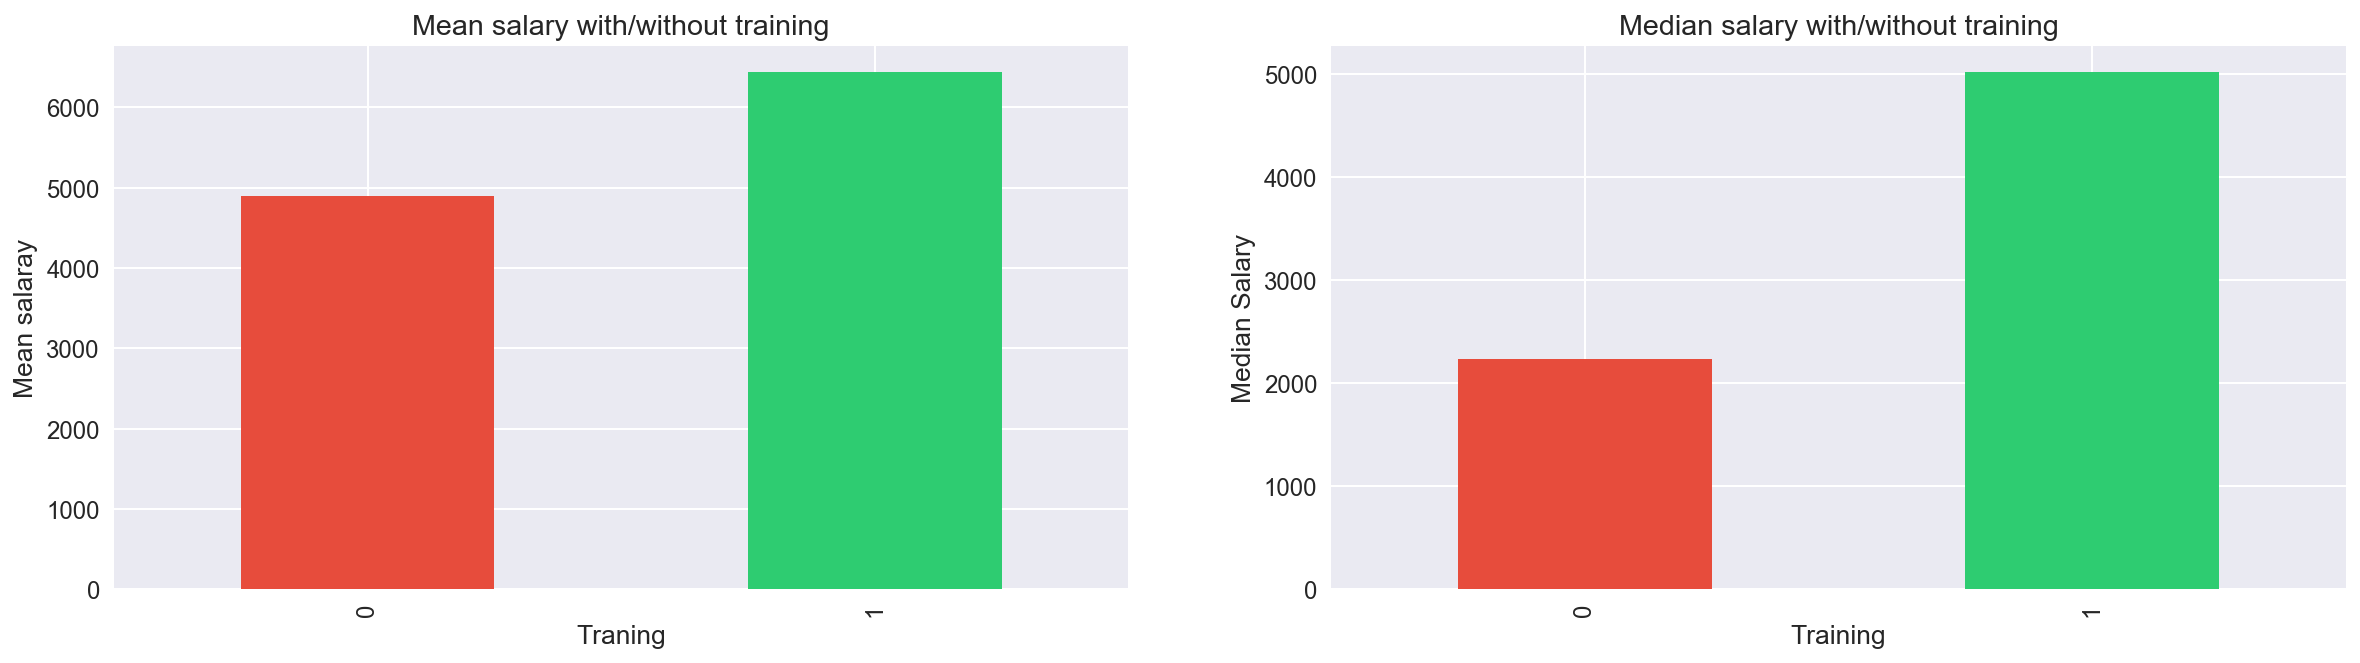

In [143]:
plt.figure(figsize=(20,5))
axes = plt.subplot(121)
matched.groupby(['treat'])['re78'].mean().plot.bar(color=[COLOR_NO_TREAT, COLOR_TREAT])
plt.title('Mean salary with/without training')
plt.ylabel('Mean salaray')
plt.xlabel('Traning')
plt.subplot(122)
matched.groupby(['treat'])['re78'].median().plot.bar(color=[COLOR_NO_TREAT, COLOR_TREAT])
plt.title('Median salary with/without training')
plt.ylabel('Median Salary')
plt.xlabel('Training')

# Question 2: Applied ML
We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

- Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn. TF-IDF, short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using TfidfVectorizer. Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

- Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the feature_importances_ attribute of your random forest and discuss the obtained results.

In [ ]:
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(subset='all')
newsgroups.target_names

Here are all the target names inside the newsgroup dataset
## 2.1 Load the data, vectorize it and split it into training set and training set

In [ ]:
from  sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(newsgroups.data) 
print(np.shape(X))

Our dataset has 18846 datapoints and 173762 features. Now let split it into train, valid and test set. To do so, we created a function *get_train_valid_test_set* written in the box below.

In [ ]:
def get_train_valid_test_set(data, labels, perc_for_valid, perc_for_test):
    # returns the train, valid and test sets
    # data : n x nb_features matrix
    # perc_for_valid : value between 0 and 1 as the percentage of the dataset to be used in validation
    # perc_for_test : value between 0 and 1 as the percentage of the dataset to be used in testing
    
    uindx = np.random.permutation(np.shape(data)[0])
    X_shuffled = data[uindx]
    labels_shf = labels[uindx]
    
    # take perc_for_test% of the dataset for testing
    X_test_shf = X_shuffled[:int(X_shuffled.shape[0]*perc_for_test)]
    y_test_shf = labels_shf[:int(X_shuffled.shape[0]*perc_for_test)]
    
    # take perc_for_valid% of the dataset for validation
    X_valid_shf = X_shuffled[int(X_shuffled.shape[0]*perc_for_test):
                             int(X_shuffled.shape[0]*(perc_for_test + perc_for_valid))]
    y_valid_shf = labels_shf[int(X_shuffled.shape[0]*perc_for_test):
                             int(X_shuffled.shape[0]*(perc_for_test + perc_for_valid))]
    
    X_train_shf = X_shuffled[int(X_shuffled.shape[0]*(perc_for_test + perc_for_valid)):]
    y_train_shf = labels_shf[int(X_shuffled.shape[0]*(perc_for_test + perc_for_valid)):]
    
    return X_test_shf, X_train_shf, X_valid_shf, y_test_shf, y_train_shf, y_valid_shf

In [ ]:
X_test, X_train, X_valid, y_test, y_train, y_valid = get_train_valid_test_set(X, newsgroups.target, 0.1, 0.1)
print('test set size : '+ str(X_test.shape))
print('valid set size : '+ str(X_valid.shape))
print('train set size : '+ str(X_train.shape))

## 2.2 Classification
**Train a random forest** on your training set. Try to **fine-tune the parameters** of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, **display a confusion matrix** of your classification pipeline. Lastly, once you assessed your model, **inspect the feature_importances_** attribute of your random forest and discuss the obtained results.

### Fine Tune max depth and number of trees

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

number_trees = [125, 300, 500, 600 ]
max_depth = [5, 8, 12, 16, 20]

best_score = 0

#Loop for hyperparameter number_trees and max_depth
for nb_t in number_trees:
    for nb_d in max_depth:

        # Random forest model
        rand_forest_model = RandomForestClassifier(n_estimators=nb_t, max_depth=nb_d)
        rand_forest_model.fit(X_train, y_train)
        y_pred_val = rand_forest_model.predict(X_valid)

        # get score
        score = accuracy_score(y_valid, y_pred_val)
        print('loading : '+ str(stepinfo/(len(number_trees)*len(max_depth))) + '% nb_trees : ' + str(nb_t) + ' depth : '
              + str(nb_d) + ' score : ' + str(score))
        
        # update best score if needed
        if score > best_score:
            best_nb_trees = nb_t
            best_max_depth = nb_d
            best_score = score
print(best_score)       

### Display confusion matrix

In [ ]:
rand_forest_model = RandomForestClassifier(n_estimators=best_nb_trees, max_depth=best_max_depth)
rand_forest_model.fit(X_train, y_train)
y_pred_test = rand_forest_model.predict(X_test)

In [ ]:
cm = confusion_matrix(y_pred_test, y_test)
#np.fill_diagonal(cm, 0)
plt.matshow(cm)
plt.title('Confusion matrix of the classifier')
plt.colorbar()
plt.show()


## TODO : regarder comment mettre la confusion matrix en % 
Faire la features importance
Analayser tout ca 